In [1]:
import numpy as np
import pandas as pd
import pickle
import sys, os
import torch
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,
    "font.size": 18,
    "font.family": "Computer Modern Roman"
    })
color_mapping = {"grassland":"g", "corn": "y", "summer barley": "r", "winter barley": "k", "winter wheat": "c", "fallow":"m"}

figure_results_path = "C:/Users/Ivica Obadic/paper_plots/attention_footprint/"

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
from datasets import dataset_utils
from datasets import sequence_aggregator
from datasets.util_functions import append_occluded_classes_label


from explainability_analysis.visualization_functions import * 
from explainability_analysis.transformer_analysis import *
from explainability_analysis.crop_spectral_signature_analysis import * 

def get_attn_weights_and_spectral_indices_for_model_and_dataset(classes_to_exclude=None):
    
    
    dataset_folder = "C:/Users/datasets/BavarianCrops/"
    base_num_classes = 12

    class_mapping = os.path.join(dataset_folder, "classmapping{}.csv".format(base_num_classes))
    train_set, valid_set, test_set = dataset_utils.get_partitioned_dataset(
        dataset_folder,
        class_mapping,
        sequence_aggregator.SequencePadder(),
        classes_to_exclude)
    
    model_root_path = "C:/Users/results/{}_classes/".format(test_set.nclasses)
    model_root_path = os.path.join(append_occluded_classes_label(model_root_path, classes_to_exclude),
                                   "right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/")
    spectral_indices = test_set.calculate_spectral_indices()
    crop_type_spectral_signature = calc_spectral_signature_per_time_frame(spectral_indices)

    predictions_path = os.path.join(model_root_path, "predictions")
    predicted_vs_true_results = pd.read_csv(os.path.join(predictions_path, "predicted_vs_true.csv"))
    attn_weights_path = os.path.join(predictions_path, "attn_weights", "postprocessed")
    
    total_temporal_attention = summarize_attention_weights_as_feature_embeddings(attn_weights_path, "layer_0", summary_fn="sum")
    weekly_avg_attn_weights_per_parcel = calc_and_save_weekly_average_attn_weights(total_temporal_attention)
    
    for parcel_id in weekly_avg_attn_weights_per_parcel.keys():
        parcel_weekly_avg_attn_weights = weekly_avg_attn_weights_per_parcel[parcel_id]
        parcel_class = spectral_indices[spectral_indices["PARCEL_ID"] == int(parcel_id)]["CLASS"].values[0]
        parcel_weekly_avg_attn_weights["CLASS"] = parcel_class
        parcel_weekly_avg_attn_weights["PARCEL_ID"] = parcel_id
    
    weekly_avg_attn_weights = pd.concat(weekly_avg_attn_weights_per_parcel.values())
    weekly_avg_attn_weights.reset_index(inplace=True)
    weekly_avg_attn_weights["WEEK"] = weekly_avg_attn_weights["WEEK"].map(lambda x: "{}-{}".format(x.split("-")[1], x.split("-")[2]))

    week_mapping = weekly_avg_attn_weights["WEEK"].unique()
    crop_type_spectral_signature["WEEK"] = crop_type_spectral_signature["WEEK"].map(lambda x: week_mapping[int(x) - 1])
    return crop_type_spectral_signature, weekly_avg_attn_weights


def plot_attn_weights(target_classes, weekly_avg_attn_weights, plot_label, y_column_name="TOTAL_ATTENTION", y_plot_label="Average temporal attention"):
    plot_data = weekly_avg_attn_weights.loc[weekly_avg_attn_weights["CLASS"].isin(target_classes)]
    plot_data = plot_data.rename(columns={"CLASS": "Class", "WEEK": "Week", y_column_name: y_plot_label})

    fig, axs = plt.subplots(figsize=(6,6))
    axs = sns.lineplot(data=plot_data, x="Week", y=y_plot_label, hue="Class", ci=None, ax = axs, palette=crop_type_color_mapping)
    n=7  # Keeps every 5th label
    [l.set_visible(False) for (i,l) in enumerate(axs.xaxis.get_ticklabels()) if i % n != 0]
    #axs.set_title("Temporal attention distribution", fontweight="bold")
    fig.tight_layout()
    plt.savefig(os.path.join(figure_results_path, '{}.eps'.format(plot_label)), dpi=400)

def calc_attn_weights_corr(target_weekly_avg_attn_weights, value_column):
    weekly_avg_class_attn_weights = target_weekly_avg_attn_weights.groupby(["CLASS", "WEEK"]).agg("mean").reset_index()
    weekly_avg_class_attn_weights_wide = weekly_avg_class_attn_weights.pivot(index="WEEK", columns="CLASS", values=value_column)
    corr_values = weekly_avg_class_attn_weights_wide.corr()
    return corr_values
    
def plot_attn_weights_corr(weekly_avg_attn_weights, target_classes, plot_label, show_corr_values=True, corr_value_column="TOTAL_ATTENTION"):
    weekly_avg_attn_weights_filtered = weekly_avg_attn_weights.loc[weekly_avg_attn_weights["CLASS"].isin(target_classes)]
    fig, axs = plt.subplots(figsize=(5, 5))
    corr_values = calc_attn_weights_corr(weekly_avg_attn_weights_filtered, corr_value_column)
    axs = sns.heatmap(corr_values,cmap="Blues", ax=axs, annot=show_corr_values)
    axs.set_ylabel('')    
    axs.set_xlabel('')
    axs.tick_params(axis='y', rotation=0)
    fig.tight_layout()
    plt.savefig(os.path.join(figure_results_path, '{}.eps'.format(plot_label)), dpi=400)

def plot_change_in_attn_weights_vs_ndvi(target_class, excluded_classes, weekly_avg_attn_weights, weekly_avg_attn_weights_excluded_classes, crop_type_spectral_signature, excluded_classes_label):
    
    weekly_avg_attn_weights_orig_and_wo_excluded_clasess = weekly_avg_attn_weights.merge(weekly_avg_attn_weights_excluded_classes, on=["PARCEL_ID", "WEEK"])
    weekly_avg_attn_weights_orig_and_wo_excluded_clasess["ATTENTION_DIFFERENCE"] = weekly_avg_attn_weights_orig_and_wo_excluded_clasess["TOTAL_ATTENTION_y"] - weekly_avg_attn_weights_orig_and_wo_excluded_clasess["TOTAL_ATTENTION_x"]
    weekly_avg_attn_weights_orig_and_wo_excluded_clasess = weekly_avg_attn_weights_orig_and_wo_excluded_clasess.loc[weekly_avg_attn_weights_orig_and_wo_excluded_clasess["CLASS_x"] == target_class]
    weekly_avg_attn_weights_orig_and_wo_excluded_clasess = weekly_avg_attn_weights_orig_and_wo_excluded_clasess.rename(
        columns={"CLASS_x": "Class", "WEEK": "Week", "ATTENTION_DIFFERENCE": "Average change in attention"})
    
    fig, axs = plt.subplots(figsize=(7, 7))
    axs = sns.lineplot(data=weekly_avg_attn_weights_orig_and_wo_excluded_clasess, x="Week", y="Average change in attention", ci=None, ax = axs, color=color_mapping[target_class])
    axs.legend(["Attention"], loc="upper left")
    
    n=7  # Keeps every 5th label
    [l.set_visible(False) for (i,l) in enumerate(axs.xaxis.get_ticklabels()) if i % n != 0]
    #axs.set_title("Change in {}".format(target_class), fontweight="bold")
    
    crop_type_spectral_signature = crop_type_spectral_signature.rename(columns={"WEEK": "Week", "NDVI": "Average NDVI"})
    crop_type_spectral_signature_target_classes = crop_type_spectral_signature.loc[crop_type_spectral_signature["CLASS"] == target_class]
    crop_type_spectral_signature_excluded_class = crop_type_spectral_signature.loc[crop_type_spectral_signature["CLASS"].isin(excluded_classes)]
    ax_ndvi = axs.twinx()
    ax_ndvi = sns.lineplot(data=crop_type_spectral_signature_target_classes, x="Week", y="Average NDVI", linestyle="dashed", ax=ax_ndvi, color=crop_type_color_mapping[target_class])
    ax_ndvi = sns.lineplot(data=crop_type_spectral_signature_excluded_class, x="Week", y="Average NDVI", ci=None, linestyle="dashed", ax=ax_ndvi)
    ax_ndvi.legend(["NDVI {}".format(target_class), "NDVI excluded crops"], loc="upper right")
    
    fig.tight_layout()
    plt.savefig(os.path.join(figure_results_path, 'change_{}_wo_{}.eps'.format(target_class, excluded_classes_label)), dpi=400)


C:\Users\Ivica Obadic\PycharmProjects\EOExplainability


In [2]:
#load the original dataset
crop_type_spectral_signature, weekly_avg_attn_weights = get_attn_weights_and_spectral_indices_for_model_and_dataset()

#load the dataset with corn excluded
crop_type_spectral_signature_wo_corn, weekly_avg_attn_weights_wo_corn = get_attn_weights_and_spectral_indices_for_model_and_dataset(["corn"])

excluded_winter_crops = ["winter barley","winter wheat", "winter rye", "winter spelt", "winter triticale"]
crop_type_spectral_signature_wo_winter_crops, weekly_avg_attn_weights_wo_winter_crops = get_attn_weights_and_spectral_indices_for_model_and_dataset(excluded_winter_crops)

MOST_FREQUENT_CROPS=["grassland","corn", "summer barley", "winter barley", "winter wheat"]

Initializing BavarianCropsDataset train partition in holl
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/holl


100%|████████████████████████████████████████████████████████████████████████████| 22407/22407 [04:08<00:00, 90.13it/s]
C:\Users\anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Dataset C:/Users/datasets/BavarianCrops/. region holl. partition train. X:20858x(71, 16), y:(20858,) with 12 classes
Initializing BavarianCropsDataset valid partition in holl
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/holl


100%|██████████████████████████████████████████████████████████████████████████████| 4211/4211 [00:48<00:00, 86.53it/s]


Dataset C:/Users/datasets/BavarianCrops/. region holl. partition valid. X:3909x(144, 16), y:(3909,) with 12 classes
Initializing BavarianCropsDataset test partition in holl
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/holl


100%|████████████████████████████████████████████████████████████████████████████| 10242/10242 [01:58<00:00, 86.16it/s]


Dataset C:/Users/datasets/BavarianCrops/. region holl. partition test. X:9583x(144, 16), y:(9583,) with 12 classes
Initializing BavarianCropsDataset train partition in krum
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/krum


100%|████████████████████████████████████████████████████████████████████████████| 20336/20336 [03:49<00:00, 88.52it/s]


Dataset C:/Users/datasets/BavarianCrops/. region krum. partition train. X:19601x(70, 16), y:(19601,) with 12 classes
Initializing BavarianCropsDataset valid partition in krum
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/krum


100%|██████████████████████████████████████████████████████████████████████████████| 5728/5728 [01:05<00:00, 87.90it/s]


Dataset C:/Users/datasets/BavarianCrops/. region krum. partition valid. X:5482x(70, 16), y:(5482,) with 12 classes
Initializing BavarianCropsDataset test partition in krum
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/krum


100%|██████████████████████████████████████████████████████████████████████████████| 4492/4492 [00:51<00:00, 86.94it/s]


Dataset C:/Users/datasets/BavarianCrops/. region krum. partition test. X:4278x(71, 16), y:(4278,) with 12 classes
Initializing BavarianCropsDataset train partition in nowa
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/nowa


100%|██████████████████████████████████████████████████████████████████████████████| 7865/7865 [01:38<00:00, 79.67it/s]
C:\Users\Ivica Obadic\PycharmProjects\EOExplainability\datasets\BavarianCrops_Dataset.py:233: RuntimeWarning: divide by zero encountered in true_divide
  self.classweights = 1 / self.hist


Dataset C:/Users/datasets/BavarianCrops/. region nowa. partition train. X:7679x(144, 16), y:(7679,) with 12 classes
Initializing BavarianCropsDataset valid partition in nowa
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/nowa


100%|████████████████████████████████████████████████████████████████████████████████| 770/770 [00:09<00:00, 80.65it/s]


Dataset C:/Users/datasets/BavarianCrops/. region nowa. partition valid. X:746x(144, 16), y:(746,) with 12 classes
Initializing BavarianCropsDataset test partition in nowa
read 12 classes
no cached dataset found. iterating through csv folders in C:/Users/datasets/BavarianCrops//csv/nowa


100%|██████████████████████████████████████████████████████████████████████████████| 3664/3664 [00:46<00:00, 78.87it/s]


Dataset C:/Users/datasets/BavarianCrops/. region nowa. partition test. X:3547x(144, 16), y:(3547,) with 12 classes
Max sequence length is 144
Calculating spectral indices for dataset: holl_test
Calculating spectral indices for dataset: krum_test
Calculating spectral indices for dataset: nowa_test
Aggregating the spectral indices based on the time frame method


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/results/12_classes/right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/predictions\\predicted_vs_true.csv'

C:\Users\IVICAO~1\AppData\Local\Temp/ipykernel_26392/1213146417.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


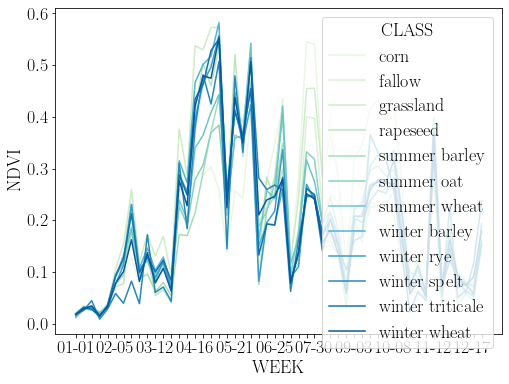

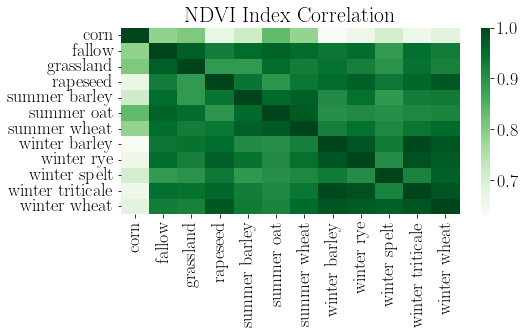

In [8]:
most_frequent_crops_spectral_signatures = crop_type_spectral_signature.loc[crop_type_spectral_signature["CLASS"].isin(MOST_FREQUENT_CROPS)]
fig, axs = plt.subplots(figsize=(8, 6))
axs = sns.lineplot(data=crop_type_spectral_signature, x="WEEK", y="NDVI", hue="CLASS", ax = axs, palette="GnBu")
n = 5  # Keeps every 5th label
[l.set_visible(False) for (i,l) in enumerate(axs.xaxis.get_ticklabels()) if i % n != 0]
fig.show()
plt.savefig(os.path.join(figure_results_path, 'ndvi_over_time.eps'), dpi=800)


fig, axs = plt.subplots(figsize=(8, 5))
ndvi_corr = calc_attn_weights_corr(crop_type_spectral_signature, "NDVI")
axs = sns.heatmap(ndvi_corr,cmap="Greens", ax=axs, annot=False, cbar=True)
axs.set_ylabel('')    
axs.set_xlabel('')
axs.set_title("NDVI Index Correlation")
fig.tight_layout()
plt.savefig(os.path.join(figure_results_path, 'ndvi_corr.eps'), dpi=800)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


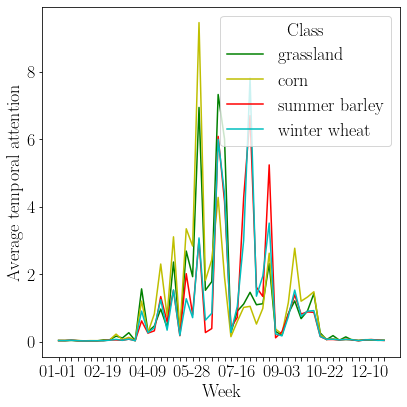

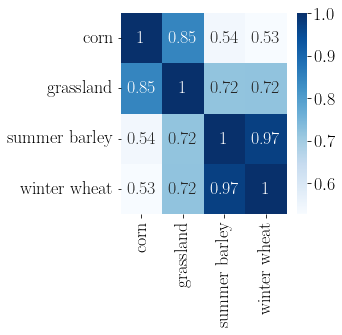

In [11]:
target_classes = ["grassland", "corn", "summer barley", "winter wheat"]
plot_attn_weights(target_classes, weekly_avg_attn_weights, "average_temp_attn_over_time")
plot_attn_weights_corr(weekly_avg_attn_weights, target_classes, "attn_weights_corr")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   CLASS   WEEK  TOTAL_ATTENTION  TOTAL_ATTENTION_DIFF
0   corn  01-01         0.039007              0.000000
1   corn  01-08         0.038091             -0.000916
2   corn  01-15         0.045859              0.007768
3   corn  01-22         0.034455             -0.011404
4   corn  01-29         0.024091             -0.010364
5   corn  02-05         0.030884              0.006793
6   corn  02-12         0.029289             -0.001595
7   corn  02-19         0.032230              0.002941
8   corn  02-26         0.051780              0.019550
9   corn  03-05         0.223425              0.171645
10  corn  03-12         0.060089             -0.163336
11  corn  03-19         0.127769              0.067680
12  corn  03-26         0.032804             -0.094965
13  corn  04-02         1.201103              1.168299
14  corn  04-09         0.268811             -0.932292
15  corn  04-16         0.823078              0.554268
16  corn  04-23         2.299748              1.476670
17  corn  

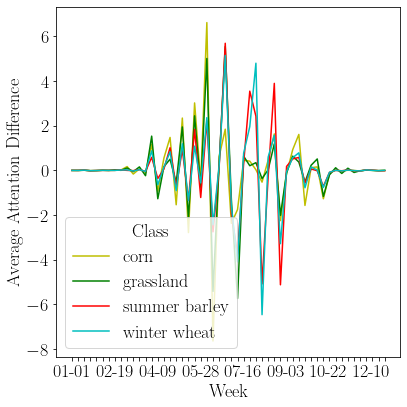

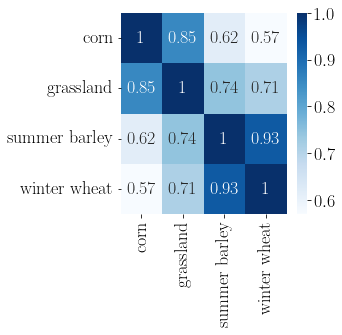

In [36]:
weekly_avg_attn_weights_diff = weekly_avg_attn_weights.groupby(["CLASS", "WEEK"])["TOTAL_ATTENTION"].mean().reset_index()
weekly_avg_attn_weights_diff = weekly_avg_attn_weights_diff.sort_values(by=["CLASS", "WEEK"])
weekly_avg_attn_weights_diff['TOTAL_ATTENTION_DIFF'] = weekly_avg_attn_weights_diff.groupby(["CLASS"])['TOTAL_ATTENTION'].diff().fillna(0)
print(weekly_avg_attn_weights_diff[weekly_avg_attn_weights_diff["CLASS"] == "corn"])

plot_attn_weights(target_classes, weekly_avg_attn_weights_diff, "average_diff_temp_attn_over_time", y_column_name="TOTAL_ATTENTION_DIFF", y_plot_label="Average Attention Difference")
plot_attn_weights_corr(weekly_avg_attn_weights_diff, target_classes, "attn_weights_diff_corr", corr_value_column="TOTAL_ATTENTION_DIFF")

In [ ]:
target_classes = ["grassland", "summer barley", "corn"]
plot_attn_weights(target_classes, weekly_avg_attn_weights_wo_winter_crops, "average_temp_attn_over_time_wo_winter_crops")
plot_attn_weights_corr(weekly_avg_attn_weights_wo_winter_crops, target_classes, "attn_weights_corr_wo_winter_crops")

In [ ]:
for target_class in target_classes:
    plot_change_in_attn_weights_vs_ndvi(target_class, excluded_winter_crops, weekly_avg_attn_weights, weekly_avg_attn_weights_wo_winter_crops, crop_type_spectral_signature, "winter_crops")

In [ ]:
target_classes = ["grassland", "summer barley", "winter wheat"]
plot_attn_weights(target_classes, weekly_avg_attn_weights_wo_corn, "average_temp_attn_over_time_wo_corn")
plot_attn_weights_corr(weekly_avg_attn_weights_wo_corn, target_classes, "attn_weights_corr_wo_corn")

In [ ]:
for target_class in target_classes:
    plot_change_in_attn_weights_vs_ndvi(target_class, ["corn"], weekly_avg_attn_weights, weekly_avg_attn_weights_wo_corn, crop_type_spectral_signature, "corn")

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8))
most_frequent_crops_weekly_attn_weights = weekly_avg_attn_weights.loc[weekly_avg_attn_weights["CLASS"].isin(MOST_FREQUENT_CROPS)]
axs = sns.lineplot(data=most_frequent_crops_weekly_attn_weights, x="WEEK", y="TOTAL_ATTENTION", hue="CLASS", ci=None, ax = axs, palette=color_mapping)
axs.set_ylabel("Average Temporal Attention")
axs.set_xlabel("Calendar Week")
#axs.set_title("Distribution of the Attention Weights over Time")
n=5  # Keeps every 5th label
[l.set_visible(False) for (i,l) in enumerate(axs.xaxis.get_ticklabels()) if i % n != 0]
print()